<a href="https://colab.research.google.com/github/cooperlee0412/ECE570FinalProject/blob/main/Test2(Noiser).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Data Training**

In [ ]:
def generate_voxel_cube(size=16, cube_size=8):
    v = np.zeros((size, size, size), dtype=np.float32)
    s, e = (size - cube_size) // 2, (size + cube_size) // 2
    v[s:e, s:e, s:e] = 1.0
    return v

dataset = torch.tensor([generate_voxel_cube() for _ in range(1000)]).unsqueeze(1)  # [B, 1, D, H, W]

<ipython-input-2-26a0673b4676>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  dataset = torch.tensor([generate_voxel_cube() for _ in range(1000)]).unsqueeze(1)  # [B, 1, D, H, W]


# **Time embedding**

In [ ]:

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = torch.exp(torch.arange(half, device=device) * -(np.log(10000) / half))
        emb = t[:, None] * emb[None, :]
        return torch.cat([emb.sin(), emb.cos()], dim=-1)

# **Simple DDPM Model**

In [ ]:

class CubeDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embed = nn.Sequential(
            SinusoidalTimeEmbedding(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 16)
        )

        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv3d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv3d(16, 1, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        x = self.relu(self.conv1(x))  # 16 channels in x
        t_embed = self.time_embed(t).view(-1, 16, 1, 1, 1)
        x = x + t_embed               # time embedding
        x = self.relu(self.conv2(x))
        return self.conv3(x)

# **Noise schedule**

In [ ]:
def get_schedule(T=100):
    betas = torch.linspace(1e-4, 0.02, T)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return betas, alphas, alpha_bars

# **Training**

In [ ]:
def train_ddpm(model, dataset, T=100, epochs=20, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    betas, alphas, alpha_bars = get_schedule(T)
    alpha_bars = alpha_bars.to(device)

    for epoch in range(epochs):
        for x0 in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x0 = x0.to(device)
            B = x0.shape[0]
            t = torch.randint(0, T, (B,), device=device).long()
            a = alpha_bars[t].view(-1, 1, 1, 1, 1)
            noise = torch.randn_like(x0)
            xt = torch.sqrt(a) * x0 + torch.sqrt(1 - a) * noise

            pred = model(xt, t.float())
            loss = nn.MSELoss()(pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1} loss: {loss.item():.4f}")

# **Sampling**

In [ ]:
@torch.no_grad()
def sample_ddpm(model, size=16, T=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    betas, alphas, alpha_bars = get_schedule(T)
    x = torch.randn(1, 1, size, size, size).to(device)

    for t in reversed(range(T)):
        t_tensor = torch.full((1,), t, device=device)
        alpha = alphas[t].to(device)
        alpha_bar = alpha_bars[t].to(device)
        beta = betas[t].to(device)
        pred_noise = model(x, t_tensor.float())

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha)) * (
            x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * pred_noise
        ) + torch.sqrt(beta) * noise

    x = torch.sigmoid(x)  #  L = [0, 1]
    return x.cpu().squeeze().numpy()

# **Visualization**

In [ ]:
def plot_cube(cube, threshold=0.5):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(cube > threshold, edgecolor='k')
    plt.title("Thresholded Output")
    plt.show()

def show_middle_slice(cube):
    plt.imshow(cube[cube.shape[0]//2], cmap='gray')
    plt.title("Middle Slice (Raw Output)")
    plt.axis('off')
    plt.show()

# **Run Training & Sampling**

Epoch 1/20: 100%|██████████| 63/63 [00:15<00:00,  4.16it/s]


Epoch 1 loss: 0.2534


Epoch 2/20: 100%|██████████| 63/63 [00:13<00:00,  4.74it/s]


Epoch 2 loss: 0.2898


Epoch 3/20: 100%|██████████| 63/63 [00:13<00:00,  4.67it/s]


Epoch 3 loss: 0.3136


Epoch 4/20: 100%|██████████| 63/63 [00:13<00:00,  4.74it/s]


Epoch 4 loss: 0.1557


Epoch 5/20: 100%|██████████| 63/63 [00:13<00:00,  4.73it/s]


Epoch 5 loss: 0.0593


Epoch 6/20: 100%|██████████| 63/63 [00:13<00:00,  4.63it/s]


Epoch 6 loss: 0.0585


Epoch 7/20: 100%|██████████| 63/63 [00:13<00:00,  4.57it/s]


Epoch 7 loss: 0.0758


Epoch 8/20: 100%|██████████| 63/63 [00:13<00:00,  4.73it/s]


Epoch 8 loss: 0.1196


Epoch 9/20: 100%|██████████| 63/63 [00:13<00:00,  4.72it/s]


Epoch 9 loss: 0.0948


Epoch 10/20: 100%|██████████| 63/63 [00:13<00:00,  4.73it/s]


Epoch 10 loss: 0.0482


Epoch 11/20: 100%|██████████| 63/63 [00:13<00:00,  4.73it/s]


Epoch 11 loss: 0.0564


Epoch 12/20: 100%|██████████| 63/63 [00:13<00:00,  4.76it/s]


Epoch 12 loss: 0.1180


Epoch 13/20: 100%|██████████| 63/63 [00:13<00:00,  4.77it/s]


Epoch 13 loss: 0.0498


Epoch 14/20: 100%|██████████| 63/63 [00:13<00:00,  4.72it/s]


Epoch 14 loss: 0.0422


Epoch 15/20: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]


Epoch 15 loss: 0.0547


Epoch 16/20: 100%|██████████| 63/63 [00:13<00:00,  4.67it/s]


Epoch 16 loss: 0.0430


Epoch 17/20: 100%|██████████| 63/63 [00:13<00:00,  4.62it/s]


Epoch 17 loss: 0.0403


Epoch 18/20: 100%|██████████| 63/63 [00:13<00:00,  4.58it/s]


Epoch 18 loss: 0.0409


Epoch 19/20: 100%|██████████| 63/63 [00:13<00:00,  4.67it/s]


Epoch 19 loss: 0.0342


Epoch 20/20: 100%|██████████| 63/63 [00:13<00:00,  4.72it/s]


Epoch 20 loss: 0.0352


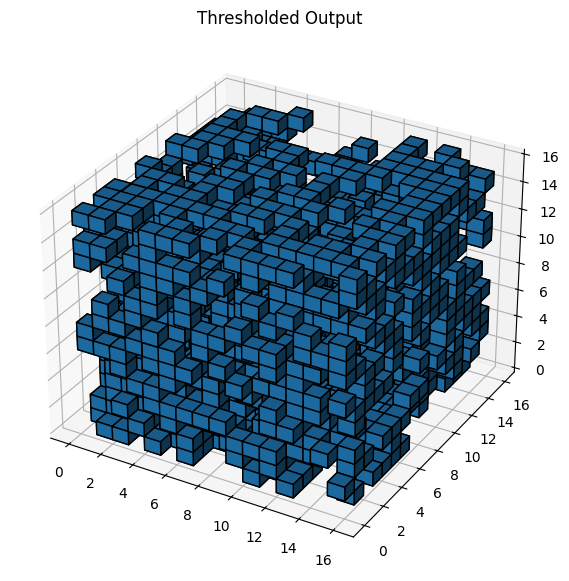

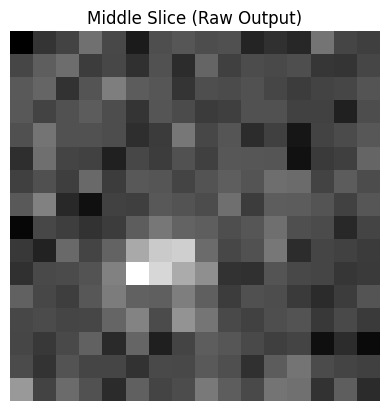

In [ ]:
model = CubeDenoiser()
train_ddpm(model, dataset, epochs=20, T=100)

gen = sample_ddpm(model, T=100)
plot_cube(gen, threshold=0.5)
show_middle_slice(gen)